In [20]:
import pandas as pd
import numpy as np
from datetime import datetime
from pyecharts.charts import Bar, Map
from pyecharts import options as opts
import warnings
warnings.filterwarnings('ignore')
# 加载数据
data = pd.read_excel('data/日化.xlsx')

# 打印列名（精确输出，避免隐藏字符影响）
print("列名（原始）：", data.columns.tolist())
print("列名（带引号）：", [f"'{col}'" for col in data.columns])

# 查看数据概况
print(data.head())
print(data.info())

列名（原始）： ['订单编码', '订单日期', '客户编码', '所在区域', '所在省份', '所在地市', '商品编号', '订购数量', '订购单价', '金额']
列名（带引号）： ["'订单编码'", "'订单日期'", "'客户编码'", "'所在区域'", "'所在省份'", "'所在地市'", "'商品编号'", "'订购数量'", "'订购单价'", "'金额'"]
     订单编码                 订单日期    客户编码 所在区域 所在省份      所在地市  商品编号  订购数量 订购单价  \
0  D31313  2019-05-16 00:00:00  S22796   东区  浙江省       台州市  X091   892  214   
1  D21329  2019-05-14 00:00:00  S11460   东区  安徽省       宿州市  X005   276  185   
2  D22372  2019-08-26 00:00:00  S11101   北区  山西省       忻州市  X078  1450  116   
3  D31078  2019-04-08 00:00:00  S10902   北区  吉林省  延边朝鲜族自治州  X025  1834  102   
4  D32470  2019-04-11 00:00:00  S18696   北区  北京市       北京市  X010   887   58   

         金额  
0  190888.0  
1   51060.0  
2  168200.0  
3  187068.0  
4   51446.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31452 entries, 0 to 31451
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   订单编码    31452 non-null  object 
 1   订单日期    31452 non-nul

数据样例概览
数据字段：
订单编码：唯一标识订单。
订单日期：订单生成日期（部分为数值格式，如 43601，可能为 Excel 日期格式）。
客户编码：客户标识。
所在区域：东区、北区、南区、西区。
所在省份：具体省份。
所在地市：具体城市。
商品编号：商品标识。
订购数量：商品数量。
订购单价：单价。
金额：总金额（数量 × 单价）。

清洗结果：

日期统一为标准格式（如 2019-03-11）。
去除省份冗余词，便于分析。
填充缺失值（假设日期缺失）。
删除负值或异常记录（若存在）。
校正金额字段。

In [21]:
# 2. 数据清洗
# (1) 处理日期
data['订单日期'] = data['订单日期'].astype(str).str.replace('#', '-')
data['订单日期'] = pd.to_datetime(data['订单日期'], errors='coerce')

# (2) 转换为数值型
data['订购数量'] = pd.to_numeric(data['订购数量'], errors='coerce')
data['订购单价'] = pd.to_numeric(data['订购单价'], errors='coerce')

# (3) 处理缺失值
data['订购数量'].fillna(data['订购数量'].median(), inplace=True)
data['订购单价'].fillna(data['订购单价'].median(), inplace=True)
data['订单日期'].fillna(data['订单日期'].mode()[0], inplace=True)
data['所在区域'].fillna('未知区域', inplace=True)  # 填充区域缺失值
data['所在省份'].fillna('未知省份', inplace=True)  # 填充省份缺失值

In [22]:
# (4) 过滤异常值
print("过滤前行数：", len(data))
data = data[(data['订购数量'] > 0) & (data['订购单价'] > 0)]
print("过滤后行数：", len(data))

# (5) 去除列名空格
data.columns = data.columns.str.strip()

过滤前行数： 31452
过滤后行数： 31452


In [23]:
# 3. 检查清洗后数据
print("清洗后列名：", data.columns.tolist())
print("清洗后数据预览：\n", data.head())

清洗后列名： ['订单编码', '订单日期', '客户编码', '所在区域', '所在省份', '所在地市', '商品编号', '订购数量', '订购单价', '金额']
清洗后数据预览：
      订单编码       订单日期    客户编码 所在区域 所在省份      所在地市  商品编号    订购数量   订购单价  \
0  D31313 2019-05-16  S22796   东区  浙江省       台州市  X091   892.0  214.0   
1  D21329 2019-05-14  S11460   东区  安徽省       宿州市  X005   276.0  185.0   
2  D22372 2019-08-26  S11101   北区  山西省       忻州市  X078  1450.0  116.0   
3  D31078 2019-04-08  S10902   北区  吉林省  延边朝鲜族自治州  X025  1834.0  102.0   
4  D32470 2019-04-11  S18696   北区  北京市       北京市  X010   887.0   58.0   

         金额  
0  190888.0  
1   51060.0  
2  168200.0  
3  187068.0  
4   51446.0  


In [24]:
# 4. 可视化
# (1) 区域订单金额分布
region_amount = data.groupby('所在区域')['金额'].sum()
bar = (
    Bar()
    .add_xaxis(list(region_amount.index))
    .add_yaxis("金额", list(region_amount.values))
    .set_global_opts(title_opts=opts.TitleOpts(title="各区域订单金额"))
)
bar.render_notebook()

# (2) 省份金额分布
province_amount = data.groupby('所在省份')['金额'].sum()
map_chart = (
    Map()
    .add("金额", [*province_amount.items()], "china")
    .set_global_opts(
        title_opts=opts.TitleOpts(title="各省份订单金额分布"),
        visualmap_opts=opts.VisualMapOpts(max_=province_amount.max())
    )
)
map_chart.render_notebook()

In [25]:
# 特征提取
data['月份'] = data['订单日期'].dt.month
data['星期几'] = data['订单日期'].dt.weekday

# 编码分类变量
data = pd.get_dummies(data, columns=['所在区域', '所在省份', '商品编号'], drop_first=True)
X = data.drop(columns=['订单编码', '订单日期', '客户编码', '所在地市', '金额'])
y = data['金额']

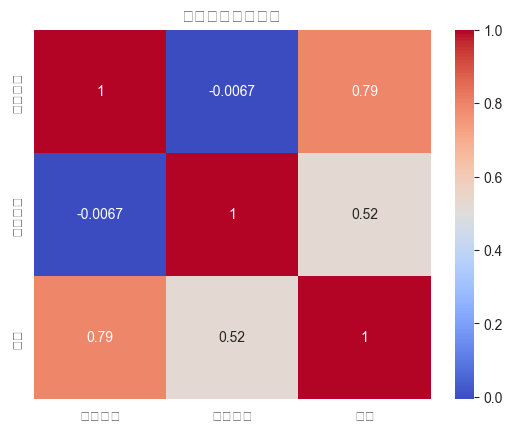

与金额相关性：
 订购数量    0.793938
订购单价    0.524513
金额      1.000000
Name: 金额, dtype: float64


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# 数值特征相关性
corr = data[['订购数量', '订购单价', '金额']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("特征相关性热力图")
plt.show()

# 输出重要性高的特征（后续模型会确认）
print("与金额相关性：\n", corr['金额'])

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练模型
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 评估
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}, R²: {r2:.2f}")

# 特征重要性
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("特征重要性：\n", importance.head(10))

ValueError: Input y contains NaN.